In [2]:
!pip install "gluonts[torch]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 32.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [5]:
# Load data from a CSV file into a PandasDataset
df = pd.read_csv(
    "logreturnsArgentina2.csv",
    index_col = 0,
    parse_dates=True,

)

df.reset_index(inplace = True)
df = df.drop("BBV.Banco", axis=1)
df.set_index("Date", inplace=True)

In [6]:
df['YPF.Energia']

Date
2020-01-03    0.001385
2020-01-06    0.019476
2020-01-07   -0.030044
2020-01-08    0.003343
2020-01-09    0.009469
                ...   
2023-12-22   -0.018571
2023-12-26   -0.029603
2023-12-27   -0.048435
2023-12-28    0.014077
2023-12-29    0.041003
Name: YPF.Energia, Length: 971, dtype: float64

In [7]:
# If your index is not a datetime type, convert it to datetime
df.index = pd.to_datetime(df.index)
# For example, if your data is daily, set the frequency to 'D'
df = df.asfreq('D')


In [8]:
dataset = PandasDataset(df, target='YPF.Energia')

# Split the data for training and testing
training_data, test_gen = split(dataset, offset=-120)
test_data = test_gen.generate_instances(prediction_length=20, windows=6)

# Train the model and make predictions
model = DeepAREstimator(
    prediction_length=20, freq="D", trainer_kwargs={"max_epochs": 10}
).train(training_data)

forecasts = list(model.predict(test_data.input))



INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name  | Type        | Params | In sizes                                                         | Out sizes   
------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | [[1, 1], [1, 1], [1, 1112, 4], [1, 1112], [1, 1112], [

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached -1.24878 (best -1.24878), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.24878 (best -1.24878), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -1.29568 (best -1.29568), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.29568 (best -1.29568), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -1.38244 (best -1.38244), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global s

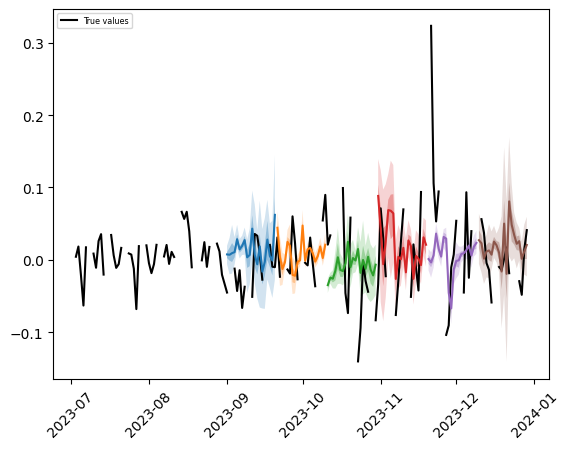

In [10]:
# Plot predictions
plt.plot(df["2023-07":], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-small")
plt.xticks(rotation=45)
plt.show()